In [12]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from feature_extraction import graph_feature_extraction, seg_feature_extraction
from loader import hetero_graph_loader
from utils import prep
from matplotlib import pyplot as plt
import numpy as np
import torch 
import pandas as pd
from evaluation import evaluation
from torch_geometric.transforms import RemoveIsolatedNodes

from itertools import product

from sklearn.metrics import accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
octa_dr_dict = {"Healthy": 0, "DM": 1, "PDR": 2, "Early NPDR": 3, "Late NPDR": 4}

data_type = "DCP"

vessel_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_vessel_graph"
void_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_void_graph"
hetero_edges_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_heter_edges"
label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv"


train_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "train",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "test",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

In [94]:
octa_dr_dict_update = {"Healthy": 0, "DM": 0, "PDR": 1, "Early NPDR": 2, "Late NPDR": 2}
train_dataset.update_class(octa_dr_dict_update)
test_dataset.update_class(octa_dr_dict_update)


In [8]:
# remove isolated nodes
for data in train_dataset:
    RemoveIsolatedNodes()(data) 

for data in test_dataset:
    RemoveIsolatedNodes()(data) 


# do data imputation
prep.hetero_graph_imputation(train_dataset)
prep.hetero_graph_imputation(test_dataset)

# extract graph features
train_g_extractor = graph_feature_extraction.GraphFeatureExtractor(train_dataset.hetero_graphs, mode=torch.mean)# 
train_g_feature_dict = train_g_extractor.get_feature_dict()
train_g_faz_feature_dict = train_g_extractor.get_faz_feature_dict()

test_g_extractor = graph_feature_extraction.GraphFeatureExtractor(test_dataset.hetero_graphs, mode=torch.mean)# 
test_g_feature_dict = test_g_extractor.get_feature_dict()
test_g_faz_feature_dict = test_g_extractor.get_faz_feature_dict()

In [9]:
#extract segmentation features
seg_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_seg"
seg_extractor = seg_feature_extraction.SegFeatureExtractor(seg_path)
seg_feature_dict = seg_extractor.get_feature_dict()


In [10]:
train_comb_feature_dict = prep.create_combined_feature_dict(train_g_feature_dict,train_g_faz_feature_dict, seg_feature_dict, train_dataset)
test_comb_feature_dict = prep.create_combined_feature_dict(test_g_feature_dict,test_g_faz_feature_dict, seg_feature_dict, test_dataset)

In [74]:
x_train = np.array([val[0] for val in train_comb_feature_dict.values()])
y_train = np.array([val[1] for val in train_comb_feature_dict.values()])

x_test = np.array([val[0] for val in test_comb_feature_dict.values()])
y_test = np.array([val[1] for val in test_comb_feature_dict.values()])

In [83]:
param_grid_rf = {'max_depth': [4, 5, 6, 8], 'max_features': ["sqrt", "log2"], 'class_weight': ['balanced','balanced_subsample', None], 'n_estimators': [100,  300]} 


best_params = None
best_bal_accuracy = 0
best_auc = 0

# Hyperparameter search loop
for param_set in product(*param_grid_rf.values()):
    current_params = dict(zip(param_grid_rf.keys(), param_set))

    # Train the model on the training set
    current_model = RandomForestClassifier(**current_params) 
    current_model.fit(x_train, y_train)

    # Evaluate on the validation set
    val_predictions = current_model.predict(x_test)
    val_prob_pred = current_model.predict_proba(x_test)
    current_accuracy = balanced_accuracy_score(y_test, val_predictions)
    _, _, roc_auc = evaluation.roc_auc_multiclass(y_test, torch.nn.functional.softmax(torch.tensor(np.array(val_prob_pred).squeeze()), dim = 1))
    current_auc = np.mean(list(roc_auc.values()))


    # Update best parameters if current model is better
    if current_auc > best_auc:
        best_auc = current_auc
        best_params = current_params


rf_best = RandomForestClassifier(**best_params) # , class_weight='balanced'
_=rf_best.fit(x_train, y_train)


{'max_depth': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'n_estimators': 100}
0.8082901554404145
0.664372898243866


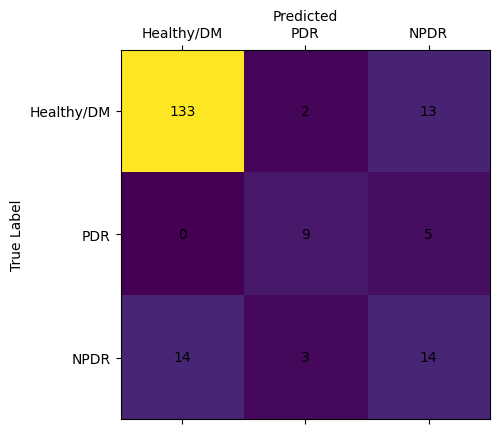

0.8771003844310346


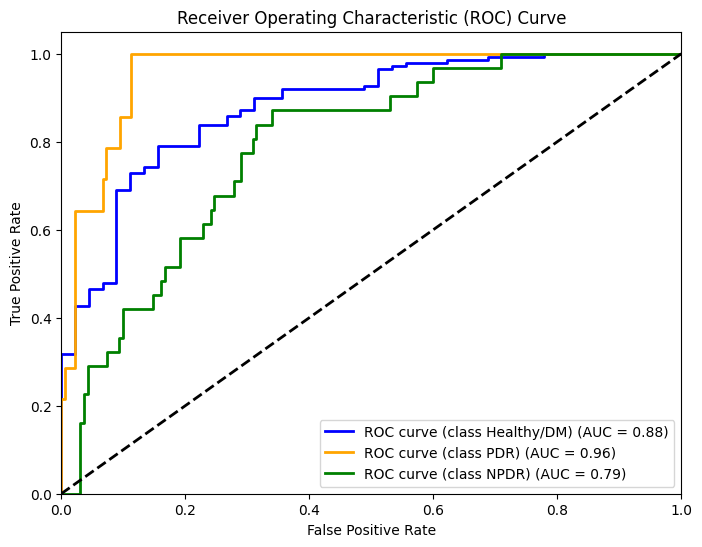

In [90]:
print(best_params)

y_p = rf_best.predict(x_test)
print(accuracy_score(y_test, y_p))
print(balanced_accuracy_score(y_test, y_p))
fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_test, y_p, ["Healthy/DM","PDR", "NPDR"], ax) #, "Early NPDR", "Late NPDR" , 3, 4 # ["Healthy/DM", "PDR", "NPDR"]
plt.show()


y_prob = rf_best.predict_proba(x_test)
mean_auc = np.mean(list(roc_auc.values()))
print(mean_auc)
evaluation.plot_roc_curve(y_test, torch.nn.functional.softmax(torch.tensor(np.array(y_prob).squeeze()), dim = 1), class_labels = ["Healthy/DM", "PDR", "NPDR"])  #["Healthy","DM", "PDR", "Early NPDR", "Late NPDR"] 
_, _, roc_auc = evaluation.roc_auc_multiclass(y_test, torch.nn.functional.softmax(torch.tensor(np.array(y_prob).squeeze()), dim = 1))



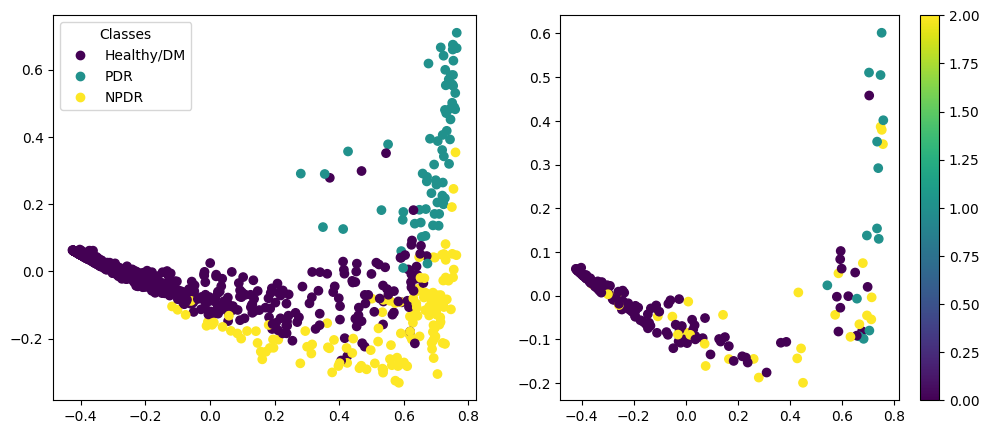

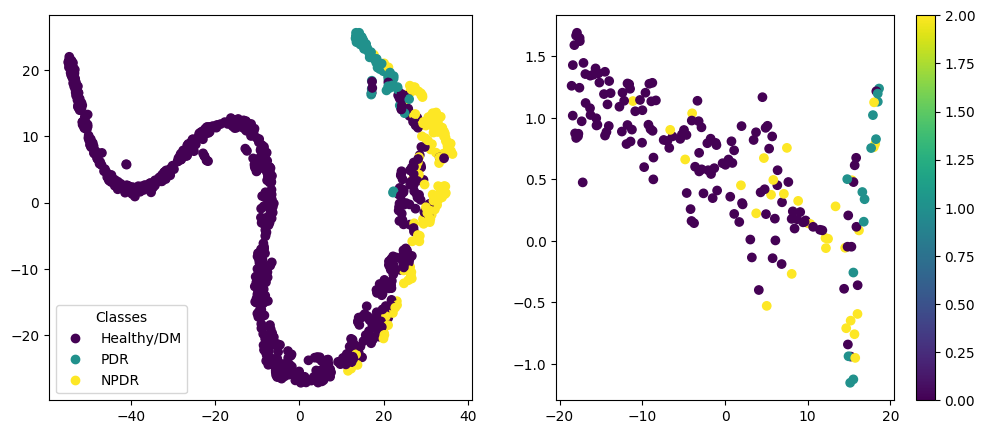

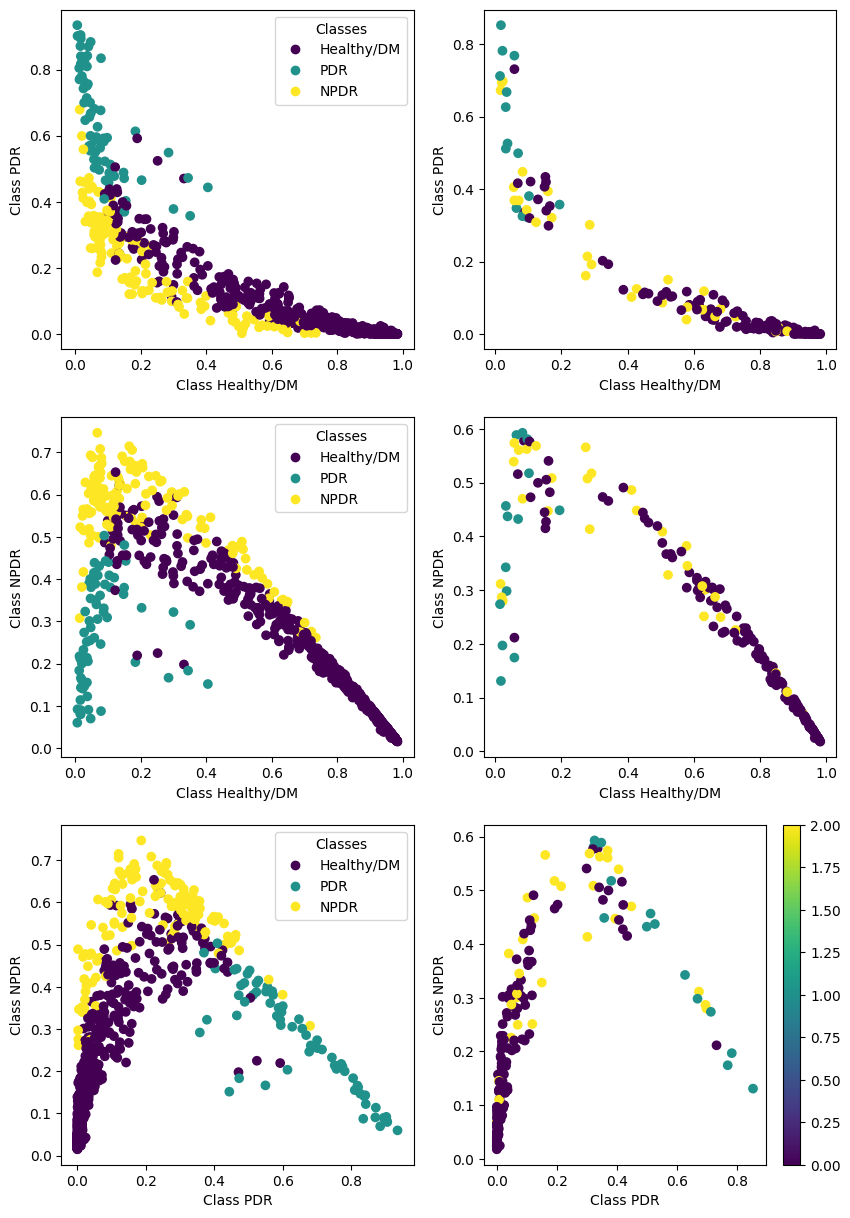

In [91]:
# tsne embedding for visualization
y_prob_train = rf_best.predict_proba(x_train)
y_prob_test = rf_best.predict_proba(x_test)

evaluation.pca_transform_plot(y_prob_train, y_prob_test, y_train, y_test, ["Healthy/DM", "PDR", "NPDR"])
evaluation.tsne_transform_plot(y_prob_train, y_prob_test, y_train, y_test, ["Healthy/DM", "PDR", "NPDR"])


evaluation.embedding_plot(y_prob_train, y_prob_test, y_train, y_test, ["Healthy/DM", "PDR", "NPDR"])

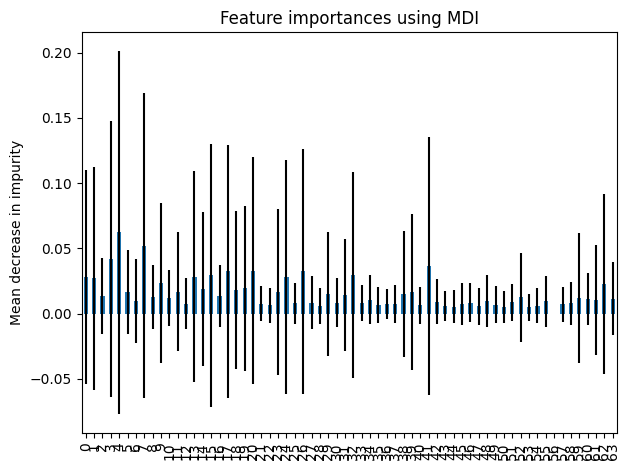

In [92]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# last features are the segmentation features